# Variable Precedence

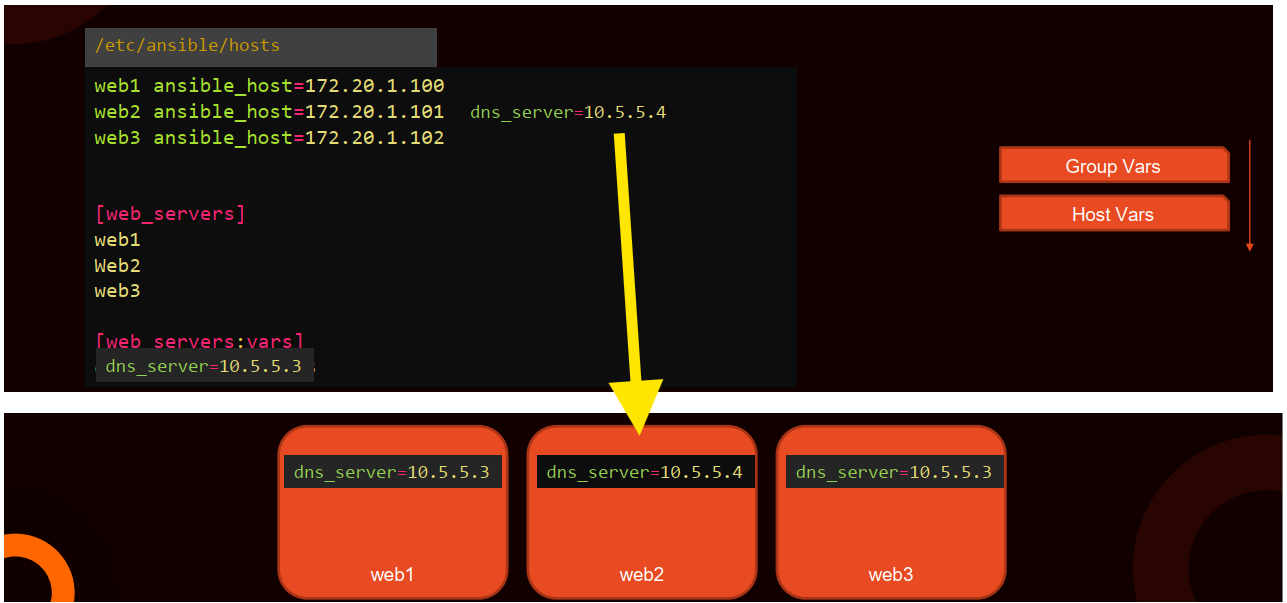

**What if you have a variable defined in two different places?**
* For example, in this inventory file, I have a variable defined for each host with its IP address.
* The `ansible_host` is a host variable.
* We also have the host, part of a group called `web_servers`.
* We know that all of our hosts in this group are to be configured with the same DNS server, so we set up a group variable called `dns_server` with the IP of the server.


**Now, when the Ansible playbook is run, Ansible creates these host objects in its memory.**
* It then identifies which group each host belongs to and then associates the group variables with each host.
* Each host gets its own copy of that variable, and that is used throughout the playbook execution.

**What if I define the same variable on the host as well?**
* For web2, let's say the DNS server is: `dns_server=10.5.5.4`.
* **Which one would be considered by Ansible?**


When an Ansible playbook is run, it first associates the group variables and then associates the host variables.
* The variable defined at the host level takes precedence over the variable defined at the group level, and that's called **variable precedence**.
* **Host variables take precedence over group variables**.

---

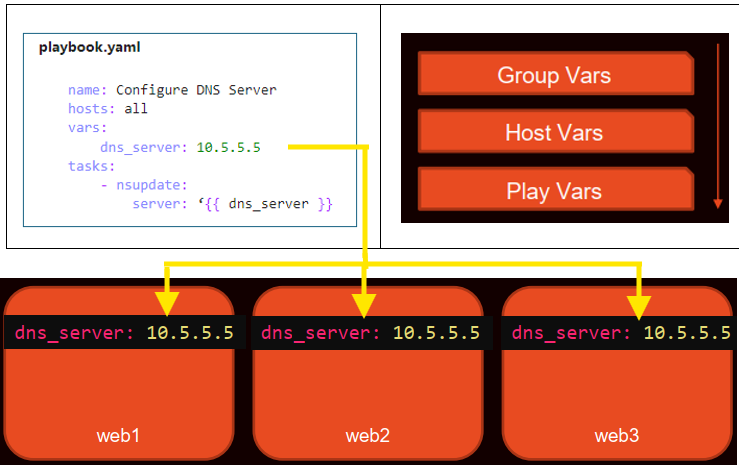

**What about variables defined within a playbook?**
* For example, inside our playbook that configures the DNS server, we have defined a variable with a different value for the DNS server.
* Also, we have the same variable defined at the group level, host level, and at the playbook level.
* In that case, whatever we define at the **playbook level overrides the variables set on the others**.

---

```bash
$ anisble-playbook playbook.yaml --extra-vars dns_server=10.5.5.6
```

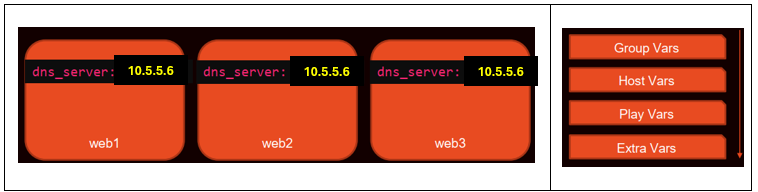

We can even pass in the same information as an extra variable while running the playbook using the `extra-vars` option.
* Well, in that case, that `extra-vars` option takes the highest precedence.
* The value passed in as an `extra-vars` option to the command line is considered the highest priority and overrides all other values specified in all other places.


# Order of Variable Precedence

A comprehensive list of the different options and their precedence is given in the Ansible documentation here: **https://docs.ansible.com/ansible/latest/playbook_guide/playbooks_variables.html**

Note that the order of precedence is from top to bottom.

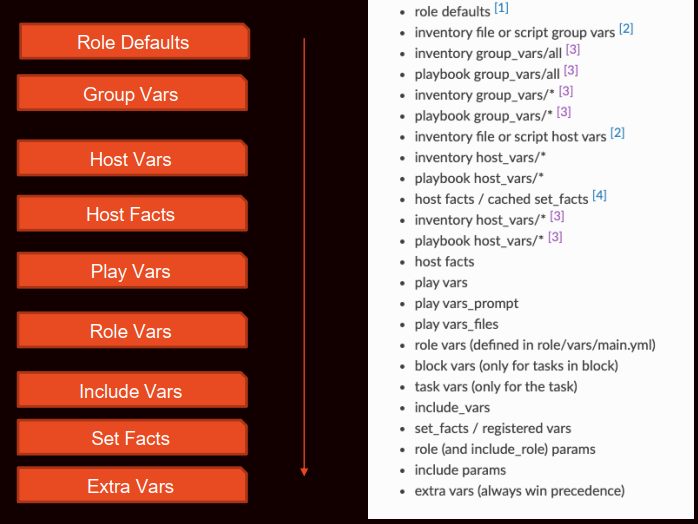

# Register Variables

At times, you may have a requirement to store the output of one task to use it later.
* For example, in this simple playbook, we have a task that prints the output of the file `etc/hosts` on a server.
* Let's add another task to print the output of the first command on screen using the debug module.

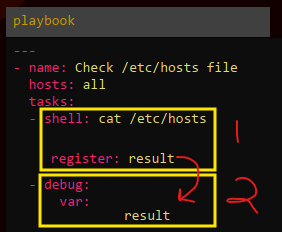

***How do we capture the output of the first command and pass it to the second command?***
* Use the **`register` directive** with the first command and specify a variable name.
* The output will now be captured into this variable.
* Then specify the same variable in the `var` option of the `debug` module.
* The variable named `result` is now accessible for the duration of this playbook.

**Below is the output when you print the variable.**

```json
ok: [web2
] => {
    "output": {
        "ansible_facts": {
            "discovered_interpreter_python": "/usr/bin/python"
        },
        "changed": true,
        "cmd": "cat /etc/hosts",
        "failed": false,
        "rc": 0,
        "start": "2019-09-12 05:25:34.158877",
        "end": "2019-09-12 05:25:34.161974",
        "delta": "0:00:00.003097",
        "stderr": "",
        "stderr_lines": [],
        "stdout": "127.0.0.1\tlocalhost\n::1\tlocalhost ip6-localhost ip6-loopback\
mcastprefix\nff02: : 1\tip6-allnodes\nff02: : 2\tip6-allrouters\n172.20.1.101\tweb
"stdout_lines": [
            "127.0.0.1\tlocalhost",
            "::1\tlocalhost ip6-localhost ip6-loopback",
            "fe00::0\tip6-localnet",
            "ff00::0\tip6-mcastprefix",
            "ff02::1\tip6-allnodes",
            "ff02::2\tip6-allrouters",
            "172.20.1.101\tweb2"
        ]
    }
}
```

**Now the data stored in the variable depends entirely on what module was run.**
* Different modules output data in different formats.
* In this case, the variable stores the result of the command execution since we use the `Shell` module.
* The result includes the return code specified by `rc` (return code).
* This would be zero if the command runs successfully.
* Anything other than zero indicates that the command may have run into a problem.
* The result also has:
    * the `start` time of the command,
    * the `end` time of the command, 
    * the `delta` indicating the time it took for the commands to complete execution, as well as
    * the `stdout` (standard out) and `stderr` (standard error) of the command, if any.
* Since we tried to print the contents of the `etc/host` file, they're stored in the `stdout` or `stdout_lines` parameter.

**Instead of printing all of the contents, what if you just want to print the file contents alone?**
* If you want to print the file contents alone, specify `result.stdout`.
* If you want to print the return code, specify `result.rc`.

**playbook.yaml**

```yaml
- name: Check /etc/hosts file
  host: all
  tasks:
    - shell: cat /etc/hosts
        register: result
    - debug: 
        var: result.stdout
        var: result.rc
```

**What is the scope of such registered variables?**
* Any variable created using the registered directive falls under the scope of that host.
* That variable is associated with that host and is available for the rest of the playbook execution.
* In this case, the `result` variable has the results of the command execution for its respective host.
* So remember, they're under the host scope, meaning:
    * They can still be used in the **next play** if required, and
    * They can **only be used within the scope of that host**.

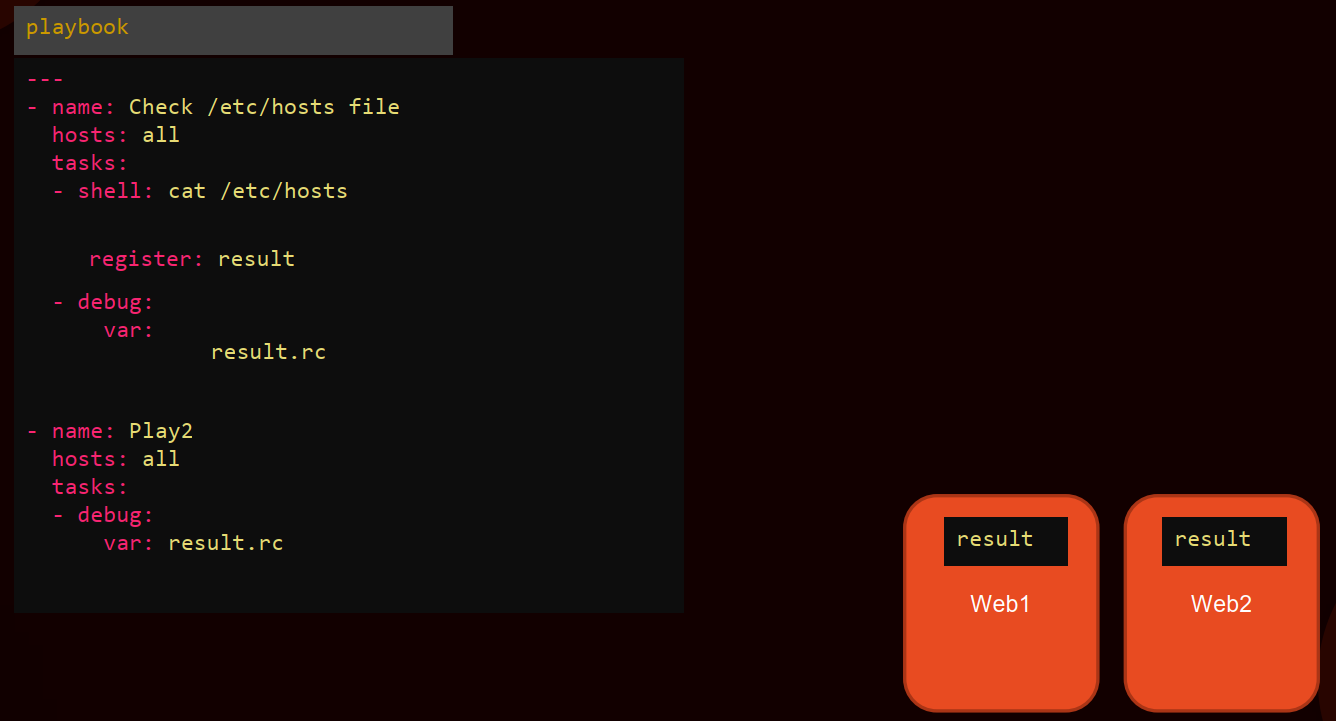

Another easy way to view the output of a task if you don't really want to use the debug module is to pass in the `-v` option while running the playbook.

```bash
$ ansible-playbook -i inventory playbook.yaml -v
```

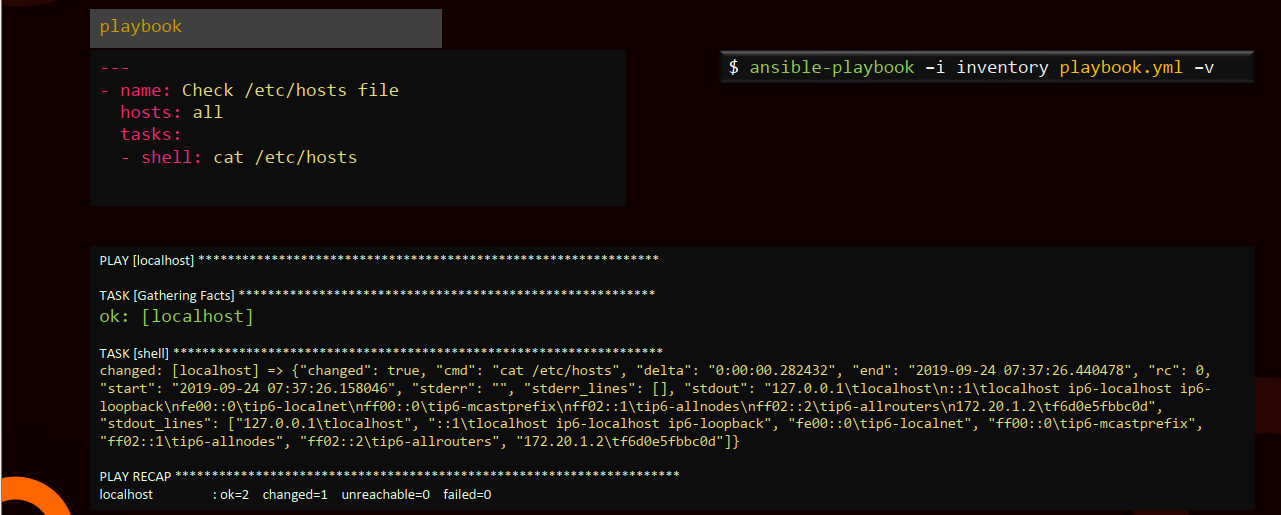